### PROCESS MINING PROJECT
Hmain Nizar - Moretti Maicol - January 2019

### The context 
Germany distributes 6.2 billion euros of farming subsidies it receives every yearfrom the EU, disbursing more towards small and medium-sized enterprises and Eco-farming practices.  There is a significant amount of money that is handled by these processes. The data we have deals with administrative and bureaucratic processes.  Our focus will primarily be on the Payment application.  This process handles the payments and manages the amount of the subsidies that would beeventually given to every individual in their respective cases.  We are interested to find out how and why some payment processes may perform not as well asothers

![title](./images/overview.png)

### The Data

In [2]:
import pandas as pd

def load_data():
    csv_path = './payment_data.csv'
    return pd.read_csv(csv_path)

data = load_data()
data.head()

,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,(case) amount_applied0,(case) amount_applied1,(case) amount_applied2,(case) amount_applied3,...,(case) young farmer,activity,concept:name,docid,doctype,eventid,lifecycle:transition,note,subprocess,success
0,-18008611495569447,Payment application-Application-mail income,0;n/a,2015/05/08 00:00:00.000,Variant 8,8,960.35,NaN,NaN,NaN,...,False,mail income,mail income,-18008611495569447,Payment application,NaN,complete,none,Application,True
1,-18008611495569447,Payment application-Application-mail valid,0;n/a,2015/05/08 00:00:00.000,Variant 8,8,960.35,NaN,NaN,NaN,...,False,mail valid,mail valid,-18008611495569447,Payment application,NaN,complete,none,Application,True
2,-18008611495569447,Payment application-Application-initialize,Document processing automaton,2015/11/06 11:21:27.376,Variant 8,8,960.35,NaN,NaN,NaN,...,False,initialize,initialize,-18008611495569447,Payment application,-1.800861e+16,complete,none,Application,True
3,-18008611495569447,Payment application-Application-begin editing,727350,2015/11/10 17:17:50.045,Variant 8,8,960.35,NaN,NaN,NaN,...,False,begin editing,begin editing,-18008611495569447,Payment application,-1.080806e+17,complete,automatic,Application,True
4,-18008611495569447,Payment application-Application-calculate,727350,2015/11/10 17:17:57.085,Variant 8,8,960.35,NaN,NaN,NaN,...,False,calculate,calculate,-18008611495569447,Payment application,-1.080806e+17,complete,automatic,Application,True


### Undesired Outcome Filtering

Now that we isolated all activites that handle the payment process, we can move to next step which would be the filtering of the data. We must isolate cases that are defined as timely. A payment is condired as timely if:
    - we filtered the data, and considered only the cases that had begin payment events.
    - if begin payment is followed by abort anywhere in the span of the case, it is not timely
    - we need Payment application-Application-initializes year is the same as the first begin payment activity


In [2]:
# our filter, since this is unique, we can extract the case value ( how many cases there are )
is_payment_application =  data['Activity']=='Payment application-Application-initialize'


data_payment = data[is_payment_application]
print(data_payment.shape)


(43809, 75)


In [3]:
data_payment['Complete Timestamp'].value_counts().shape

(43754,)

As we can see here, some values for the Timestamp are missing. 43809 - 43754.
Exactly 55 Timestamps are missing.

### Undesired outcome 1: 
The payment is late. A payment can be considered timely, if there has been a “begin payment” activity by the end of the year that was not eventually followed by “abort payment”.

In [ ]:
# This is only a snippet, do not try to execute this cell
notTimely = []

for case in cases:

    for x in range(len(case)):
        try:
            if(case[x][1] == 'Payment application-Application-initialize'):
                # parse the time to substract them and see if there is a year between initialize and first begin payment
                d1 = datetime.strptime(case[x][2], "%Y/%m/%d %H:%M:%S.%f")
                # check the second event if there is not a year between them
                d2 = datetime.strptime(case[x+1][2], "%Y/%m/%d %H:%M:%S.%f")
                d3 = d2 - d1
                # check the exact the year
                if(d3.days > 365):
                    if case[x][0] not in notTimely:
                        notTimely.append(case[x][0])
                


            if(case[x][7] == 'begin payment' and case[x+1][7] == 'abort payment'):
                if case[x][0] not in notTimely:
                    notTimely.append(case[x][0])
        except IndexError:
            pass

In [6]:

def load_not_timely():
    csv_path = './undesired1/late cases (not timely).csv'
    return pd.read_csv(csv_path)

data = load_not_timely()
data.head()
    

,Case ID,Activity,Complete Timestamp,Variant,Variant index,case(selected_risk),case (small_farmer),case (year),case (young farmer),concept:name
0,8b99873a6136cfa6,Payment application-Application-initialize,2015/11/06 11:21:27.376,Variant 2,2,False,True,2015,False,initialize
1,8b99873a6136cfa6,Payment application-Application-begin payment,2015/12/16 11:55:49.972,Variant 2,2,False,True,2015,False,begin payment
2,8b99873a6136cfa6,Payment application-Application-abort payment,2015/12/16 16:43:22.109,Variant 2,2,False,True,2015,False,abort payment
3,8b99873a6136cfa6,Payment application-Application-begin payment,2015/12/17 21:17:23.983,Variant 2,2,False,True,2015,False,begin payment
4,8b99873a6136cfa6,Payment application-Application-abort payment,2015/12/18 13:23:26.222,Variant 2,2,False,True,2015,False,abort payment


In [186]:
data = load_data()

# our filter, since this is unique, we can extract the case value ( how many cases there are )
is_late =  data['Activity']=='Payment application-Application-abort payment'

data_payment = data[is_late]

# we drop the duplicates based on their IDS
late_payment = data_payment.drop_duplicates(subset='Case ID')

print(late_payment.shape)

(26625, 75)


<img src="./images/5.PNG" alt="Drawing" style="width: 400px;"/>

### Department Stats

In [102]:
# our filter, since this is unique, we can extract the case value ( how many cases there are )
is_late =  late_payment['(case) department']=='6b'
print(" 6b :", len(late_payment[is_late]))
print("-----------")
is_late =  late_payment['(case) department']=='4e'
print(" 4e :", len(late_payment[is_late]))
print("-----------")
is_late =  late_payment['(case) department']=='e7'
print(" e7 :", len(late_payment[is_late]))
print("-----------")
is_late =  late_payment['(case) department']=='d4'
print(" d4 :", len(late_payment[is_late]))


 6b : 7470
-----------
 4e : 9064
-----------
 e7 : 4411
-----------
 d4 : 5680


Let's see the difference in years

In [120]:
# we drop the duplicates based on their IDS
data = data.drop_duplicates(subset='Case ID')


In [121]:
is_late =  late_payment['(case) year']==2015
print("Late cases in 2015")
print(len(late_payment[is_late]) , " out of total " , len(data[data['(case) year']==2015])) 
print("------------")
is_late =  late_payment['(case) year']==2016
print("Late cases in 2016")
print(len(late_payment[is_late]) , " out of total " , len(data[data['(case) year']==2016])) 
print("------------")
is_late =  late_payment['(case) year']==2017
print("Late cases in 2017")
print(len(late_payment[is_late]) , " out of total " , len(data[data['(case) year']==2017])) 

Late cases in 2015
14668  out of total  14750
------------
Late cases in 2016
10078  out of total  14552
------------
Late cases in 2017
1879  out of total  14507


In [118]:
is_year =  late_payment['(case) year']==2015
year = late_payment[is_year]

is_dep =  year['(case) department']=='4e'
he = year[is_dep]

print("4e :", len(he), " late cases out of all cases in 2015")


is_year =  late_payment['(case) year']==2016
year = late_payment[is_year]

is_dep =  year['(case) department']=='4e'
he = year[is_dep]

print("4e :", len(he), " late cases out of all cases in 2016")

is_year =  late_payment['(case) year']==2017
year = late_payment[is_year]

is_dep =  year['(case) department']=='4e'
he = year[is_dep]

print("4e :", len(he), " late cases out of all cases in 2017")

print("----------------")

is_year =  late_payment['(case) year']==2015
year = late_payment[is_year]

is_dep =  year['(case) department']=='6b'
he = year[is_dep]

print("6b :", len(he), " late cases out of all cases in 2015")


is_year =  late_payment['(case) year']==2016
year = late_payment[is_year]

is_dep =  year['(case) department']=='6b'
he = year[is_dep]

print("6b :", len(he), " late cases out of all cases in 2016")

is_year =  late_payment['(case) year']==2017
year = late_payment[is_year]

is_dep =  year['(case) department']=='6b'
he = year[is_dep]

print("6b :", len(he), " late cases out of all cases in 2017")

print("----------------")

is_year =  late_payment['(case) year']==2015
year = late_payment[is_year]


is_dep =  year['(case) department']=='d4'
he = year[is_dep]

print("d4 :", len(he), " late cases out of all cases in 2015")


is_year =  late_payment['(case) year']==2016
year = late_payment[is_year]

is_dep =  year['(case) department']=='d4'
he = year[is_dep]

print("d4 :", len(he), " late cases out of all cases in 2016")

is_year =  late_payment['(case) year']==2017
year = late_payment[is_year]

is_dep =  year['(case) department']=='d4'
he = year[is_dep]

print("d4 :", len(he), " late cases out of all cases in 2017")

print("----------------")

is_year =  late_payment['(case) year']==2015
year = late_payment[is_year]

is_dep =  year['(case) department']=='e7'
he = year[is_dep]


print("e7 :", len(he), " late cases out of all cases in 2015")


is_year =  late_payment['(case) year']==2016
year = late_payment[is_year]

is_dep =  year['(case) department']=='e7'
he = year[is_dep]

print("e7 :", len(he), " late cases out of all cases in 2016")

is_year =  late_payment['(case) year']==2017
year = late_payment[is_year]

is_dep =  year['(case) department']=='e7'
he = year[is_dep]

print("e7 :", len(he), " late cases out of all cases in 2017")





4e : 4575  late cases out of all cases in 2015
4e : 4485  late cases out of all cases in 2016
4e : 4  late cases out of all cases in 2017
----------------
6b : 3770  late cases out of all cases in 2015
6b : 3698  late cases out of all cases in 2016
6b : 2  late cases out of all cases in 2017
----------------
d4 : 1914  late cases out of all cases in 2015
d4 : 1893  late cases out of all cases in 2016
d4 : 1873  late cases out of all cases in 2017
----------------
e7 : 4409  late cases out of all cases in 2015
e7 : 2  late cases out of all cases in 2016
e7 : 0  late cases out of all cases in 2017


In [ ]:
4e : 4575  late cases out of all cases in 2015
4e : 4485  late cases out of all cases in 2016
4e : 4  late cases out of all cases in 2017
----------------
6b : 3770  late cases out of all cases in 2015
6b : 3698  late cases out of all cases in 2016
6b : 2  late cases out of all cases in 2017
----------------
d4 : 1914  late cases out of all cases in 2015
d4 : 1893  late cases out of all cases in 2016
d4 : 1873  late cases out of all cases in 2017
----------------
e7 : 4409  late cases out of all cases in 2015
e7 : 2  late cases out of all cases in 2016
e7 : 0  late cases out of all cases in 2017

<img src="./images/3.PNG" alt="Drawing" style="width: 500px;"/>

<img src="./images/4.PNG" alt="Drawing" style="width: 500px;"/>

(0, 160000)

<Figure size 432x288 with 0 Axes>

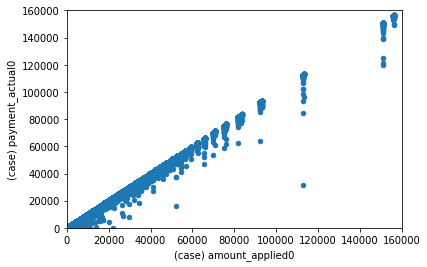

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt


fig=plt.figure(1)
late_payment.plot(kind="scatter", x="(case) amount_applied0", y="(case) payment_actual0")
axes = plt.gca()
axes.set_ylim([0,160000])
axes.set_xlim([0,160000])

### Undesired outcome 2
The case needs to be reopened, either by the department (subprocess “Change”) or due to a legal objection by the applicant (subprocess “Objection”). This may result in additional payments or reimbursements (“payment_actual{x}“ > 0, where x ≥ 1 refers to the xth payment after the initial one)

In [200]:
data = load_data()
_changed = data[data['subprocess']=='Change']
_objection = data[data['subprocess']=='Objection']
_changed = _changed.drop_duplicates(subset='Case ID')
_objection = _objection.drop_duplicates(subset='Case ID')
data = data.drop_duplicates(subset='Case ID')
is_late =  _changed['(case) year']==2015
print("Late cases in 2015")
print(len(_changed[is_late]) , " out of total " , len(data[data['(case) year']==2015])) 
print("------------")
is_late =  _changed['(case) year']==2016
print("Late cases in 2016")
print(len(_changed[is_late]) , " out of total " , len(data[data['(case) year']==2016])) 
print("------------")
is_late =  _changed['(case) year']==2017
print("Late cases in 2017")
print(len(_changed[is_late]) , " out of total " , len(data[data['(case) year']==2017])) 
print("------------") 
print("Re-opened cases: Changed:" ,len( _changed), " Objections: ", len(_objection))

Late cases in 2015
2388  out of total  14750
------------
Late cases in 2016
1563  out of total  14552
------------
Late cases in 2017
0  out of total  14507
------------
Re-opened cases: Changed: 3951  Objections:  843


Let's now look at the statistics for re-opened cases.
The median duration for re-opened cases is 14 days the mean duration for reopened cases is 61.6 days. These reimbursements and payments happen always
after there is a mistake in the calculation, so the correct amount to be calculated
takes a bit.
e7 : 32.01%, 4e : 25.78%, 6b : 23.58%, d4 : 18.64%

<img src="./images/6.PNG" alt="Drawing" style="width: 500px;"/>

The median duration 14.8 weeks for late cases ( not timely )
the mean duration 17.1 weeks for late cases ( not timely )

The median duration for re-opened cases is 14 days
the mean duration for re-opened cases is 61.6 days

We would like to detect such cases as early as possible. Ideally, this should happen before a decision is made for this case (first occurrence of “Payment application+application+decide”). You may use data from previous years to make predictions for the current year.

### Machine Learning
<img src="./images/machine learning in this context.PNG" alt="Drawing" style="width: 700px;"/>



In our context, we would first need to add a label to each case, specifying its
timeliness. If the payment is late, timeliness would be set to false else it will be
set to true. In order to achieve this we wrote a script that is a slight modification
to our previous script

In [ ]:
for case in cases:
        if case[0][0] in truncated_notTimely:
            for x in range(len(case)):
                case[x][17] = 'false'
                tastyData.writerow(case[x])
                # add to another csv file
        else:
            for x in range(len(case)):
                case[x][17] = 'true'
                tastyData.writerow(case[x])

<img src="Pearson R.PNG" alt="Drawing" style="width: 300px;"/>

In [231]:
corr_matrix = data.corr()
print(corr_matrix["(case) amount_applied0"].sort_values(ascending=False).head(10))
print(corr_matrix["(case) amount_applied0"].sort_values(ascending=False).tail(10))

(case) amount_applied0    1.000000
(case) amount_applied3    0.999999
(case) payment_actual0    0.999795
(case) amount_applied2    0.998180
(case) amount_applied1    0.977176
(case) area               0.822678
(case) number_parcels     0.612483
(case) penalty_amount3    0.507312
Variant index             0.170253
(case) penalty_amount0    0.167370
Name: (case) amount_applied0, dtype: float64
(case) penalty_AUVP      -0.034567
(case) penalty_B3        -0.036725
(case) selected_risk     -0.045017
(case) payment_actual3   -0.069720
(case) small farmer      -0.096942
(case) basic payment           NaN
(case) greening                NaN
(case) program-id              NaN
eventid                        NaN
success                        NaN
Name: (case) amount_applied0, dtype: float64


In [238]:
# A penalty term due to violation of cross-compliance rules.
corr_matrix = data.corr()
print(corr_matrix["(case) cross_compliance"].sort_values(ascending=False).head(10))
print(corr_matrix["(case) cross_compliance"].sort_values(ascending=False).tail(10))

(case) cross_compliance    1.000000
(case) penalty_amount2     0.686159
(case) penalty_amount1     0.583567
(case) penalty_CC          0.554836
(case) penalty_amount0     0.535910
(case) penalty_V5          0.272892
Variant index              0.086382
(case) number_parcels      0.070036
(case) area                0.046500
(case) rejected            0.042140
Name: (case) cross_compliance, dtype: float64
(case) amount_applied2   -0.040083
(case) payment_actual2   -0.348675
(case) amount_applied3         NaN
(case) basic payment           NaN
(case) greening                NaN
(case) payment_actual3         NaN
(case) penalty_amount3         NaN
(case) program-id              NaN
eventid                        NaN
success                        NaN
Name: (case) cross_compliance, dtype: float64


In [228]:
corr_matrix = data.corr()
print(corr_matrix["(case) area"].sort_values(ascending=False).head(10))
print(corr_matrix["(case) area"].sort_values(ascending=False).tail(10))

(case) area               1.000000
(case) number_parcels     0.856593
(case) amount_applied3    0.846370
(case) amount_applied0    0.822678
(case) payment_actual0    0.821515
(case) amount_applied2    0.821273
(case) amount_applied1    0.819556
(case) penalty_amount3    0.409337
(case) payment_actual3    0.280444
(case) penalty_B2         0.266639
Name: (case) area, dtype: float64
(case) rejected        -0.058435
(case) penalty_AUVP    -0.059774
(case) penalty_B3      -0.063103
(case) selected_risk   -0.083882
(case) small farmer    -0.171297
(case) basic payment         NaN
(case) greening              NaN
(case) program-id            NaN
eventid                      NaN
success                      NaN
Name: (case) area, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000272814734A8>,
      dtype=object)

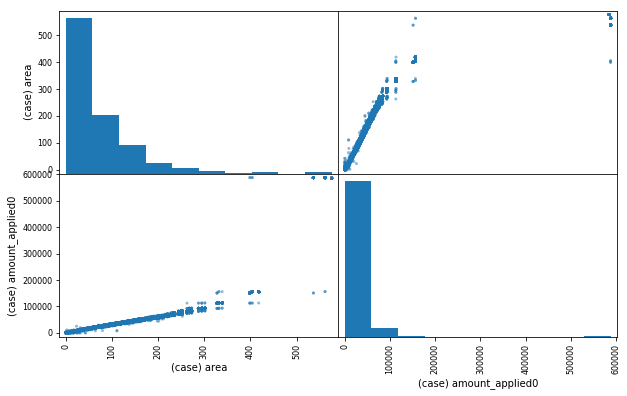

In [243]:
from pandas.plotting import scatter_matrix

attributes = ["(case) department", "(case) area", "(case) amount_applied0"]
scatter_matrix(data[attributes], figsize = (10,6))

Now that we have a generated csv file containing all the attributes that we need
we can proceed to the normalization of the data. The data that the model will
use to be trained with is very important

<img src="./images/data cleansing.PNG" alt="Drawing" style="width: 700px;"/>

<img src="./images/results_of_prediction.PNG" alt="Drawing" style="width: 700px;"/>

<img src="./images/Random Forest.PNG" alt="Drawing" style="width: 700px;"/>

<img src="./images/Decision Tree.PNG" alt="Drawing" style="width: 700px;"/>